In [ ]:
# https://git.codenrock.com/gpt-or-human/cnrprod-team-36242/gpt-human-model

### Import


In [125]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn import svm
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
import string

from random import randint
nltk.download('punkt')


# import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# import torch

from catboost import Pool, CatBoostClassifier

[nltk_data] Downloading package punkt to C:\Users\Artem
[nltk_data]     Pereverzev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### EDA

In [193]:
data = pd.read_csv("data/train.csv")
data.head()


,q_title,q_id,label,ans_text,line_id
0,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,hu_answer,"Да ничего особенного. :)\nКорпус должен быть, ...",735ba0c5-e6b2-461a-bf5d-b7cb67d42299
1,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,ai_answer,Здравствуйте! Спасибо за интересный вопрос. Дл...,f5eb55c6-2785-4ddc-8f97-30021fd75d68
2,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,ai_answer,"To load a reusable UITableViewCell from a Nib,...",bfd3d85e-6981-423d-a138-7580530a1f85
3,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,hu_answer,"Actually, since you are building the cell in I...",b823bb82-4b05-41ec-b226-7bd0aef29711
4,How can I change UIButton title color?,ffeccbf1-eff2-42b2-a472-f2a8c70b7dbd,hu_answer,You can use -[UIButton setTitleColor:forState:...,4816a574-6bbf-4658-b37b-39d05c29dfca


In [194]:
cringe_symbs = ['\n','\t','\r','\0']
cringe_symbs = dict({i:' ' for i in cringe_symbs})
table = str.maketrans(cringe_symbs)

def clean_text(text):
    words = word_tokenize(text.lower().strip().translate(table)) 

    return " ".join(words)

data['ans_clean'] = data['ans_text'].apply(clean_text)
data['q_clean'] = data['q_title'].apply(clean_text)

n = randint(0, len(data))
data.iloc[n]['ans_clean'],data.iloc[n]['label']

("привет ! как говорится , `` классика - это то , что выжило , а современность - это то , что еще не умерло '' . шутка , конечно , но в ней есть доля правды . современная литература еще не успела стать классикой , но это не значит , что она не стоит вашего внимания . я бы порекомендовал начать с таких авторов , как харуки мураками , джон грин , гиллиан флинн , джоан роулинг и многих других . кто знает , может быть , через несколько десятилетий их произведения станут классикой ? в любом случае , не бойтесь экспериментировать и открывать для себя новых авторов . удачи в чтении !",
 'ai_answer')

In [195]:
data['label'].value_counts()

label
ai_answer    2425
hu_answer    2394
Name: count, dtype: int64

In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   q_title    4819 non-null   object
 1   q_id       4819 non-null   object
 2   label      4819 non-null   object
 3   ans_text   4819 non-null   object
 4   line_id    4819 non-null   object
 5   ans_clean  4819 non-null   object
 6   q_clean    4819 non-null   object
dtypes: object(7)
memory usage: 263.7+ KB


In [197]:
data['original_text_len'] = data['ans_text'].str.len()
data['tabs_count'] = data['ans_text'].str.count('\t')
data['tabs_count'].describe()

count    4819.000000
mean        0.004980
std         0.345727
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        24.000000
Name: tabs_count, dtype: float64

In [198]:
for i in range(len(data)):
  if data.loc[i]['tabs_count'] > 0:
    print('one ')

one 


In [199]:
data[['label', 'original_text_len']].groupby('label', as_index=False).mean()

,label,original_text_len
0,ai_answer,658.255258
1,hu_answer,1195.491646


In [200]:
data['ans_clean_len'] = data['ans_clean'].str.len()
data['q_clean_len'] = data['q_clean'].str.len()

In [201]:
ai_written = data[data['label'] == 'ai_answer']
human_written = data[data['label'] == 'hu_answer']

print ("ai_written: %i (%.1f%%)"%(len(ai_written), (len(ai_written))/len(data)*100.0))
print ("human_written: %i (%.1f%%)"%(len(human_written), (len(human_written))/len(data)*100.0))
print ("Total: %i"%len(data))

ai_written: 2425 (50.3%)
human_written: 2394 (49.7%)
Total: 4819


Text(0.5, 1.0, 'AI')

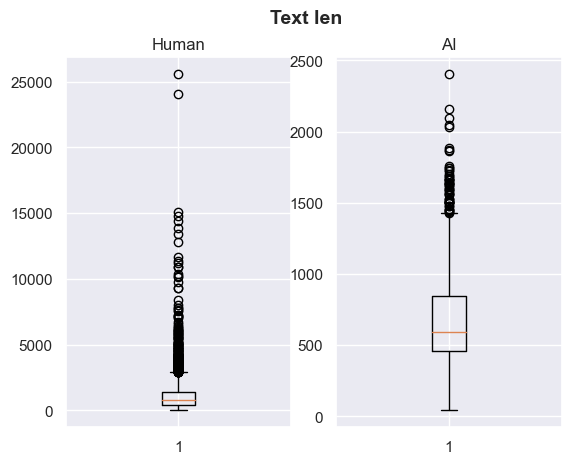

In [202]:
fig = plt.figure()
fig.suptitle('Text len', fontsize=14, fontweight='bold')

axH = fig.add_subplot(121)
axH.boxplot(human_written['ans_clean_len'])
axH.set_title('Human')

axI = fig.add_subplot(122)
axI.boxplot(ai_written['ans_clean_len'])
axI.set_title('AI')



<Axes: >

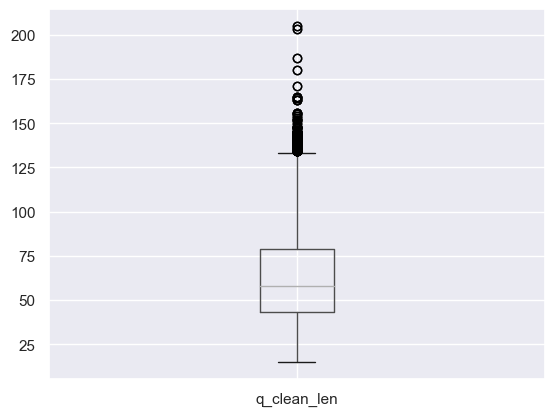

In [203]:
data.boxplot(['q_clean_len'])

### Cleaning

Можно сделать наблюдательные выводы по усатым боксам. Для ответа текст человека и машины обрезаем до 1500 смиволов. Для контекста - 130

In [204]:
data.head()


,q_title,q_id,label,ans_text,line_id,ans_clean,q_clean,original_text_len,tabs_count,ans_clean_len,q_clean_len
0,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,hu_answer,"Да ничего особенного. :)\nКорпус должен быть, ...",735ba0c5-e6b2-461a-bf5d-b7cb67d42299,да ничего особенного . : ) корпус должен быть ...,"какие комплектующие должны быть в компьютере ,...",530,0,545,145
1,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,ai_answer,Здравствуйте! Спасибо за интересный вопрос. Дл...,f5eb55c6-2785-4ddc-8f97-30021fd75d68,здравствуйте ! спасибо за интересный вопрос . ...,"какие комплектующие должны быть в компьютере ,...",686,0,702,145
2,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,ai_answer,"To load a reusable UITableViewCell from a Nib,...",bfd3d85e-6981-423d-a138-7580530a1f85,to load a reusable uitableviewcell from a nib ...,loading a reusable uitableviewcell from a nib,636,0,655,45
3,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,hu_answer,"Actually, since you are building the cell in I...",b823bb82-4b05-41ec-b226-7bd0aef29711,"actually , since you are building the cell in ...",loading a reusable uitableviewcell from a nib,425,0,432,45
4,How can I change UIButton title color?,ffeccbf1-eff2-42b2-a472-f2a8c70b7dbd,hu_answer,You can use -[UIButton setTitleColor:forState:...,4816a574-6bbf-4658-b37b-39d05c29dfca,you can use - [ uibutton settitlecolor : forst...,how can i change uibutton title color ?,331,0,349,39


In [205]:
def cutting_string(text: string, edge: int)->string:
    return text[:edge]

    
data['ans_clean'] = data['ans_clean'].apply(
        lambda x: pd.Series(cutting_string(x, 1500))
        )

data['q_clean'] = data['q_clean'].apply(
        lambda x: pd.Series(cutting_string(x, 130))
        )


<Axes: >

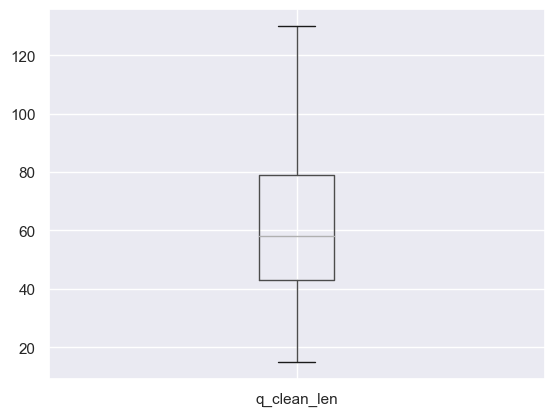

In [206]:
data['ans_clean_len'] = data['ans_clean'].str.len()
data['q_clean_len'] = data['q_clean'].str.len()
data.boxplot(['q_clean_len'])

<Axes: >

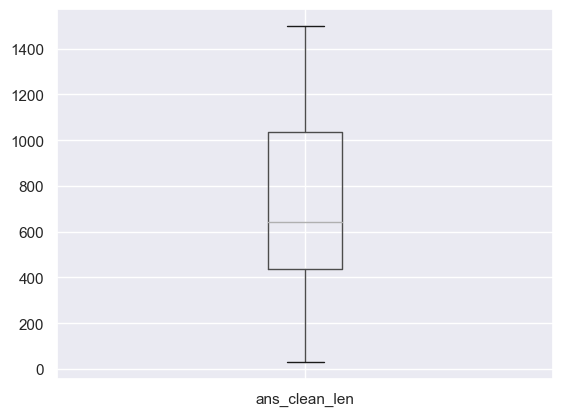

In [207]:
data.boxplot(['ans_clean_len']) # for all

### Catboost

In [209]:
data['label'] = data['label'].map({'ai_answer': 1, 'hu_answer': 0}) # 1 - AI
data.head()

,q_title,q_id,label,ans_text,line_id,ans_clean,q_clean,original_text_len,tabs_count,ans_clean_len,q_clean_len
0,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,0,"Да ничего особенного. :)\nКорпус должен быть, ...",735ba0c5-e6b2-461a-bf5d-b7cb67d42299,да ничего особенного . : ) корпус должен быть ...,"какие комплектующие должны быть в компьютере ,...",530,0,545,130
1,"Какие комплектующие должны быть в компьютере, ...",fff6c529-c037-47c8-b33b-873397243fbd,1,Здравствуйте! Спасибо за интересный вопрос. Дл...,f5eb55c6-2785-4ddc-8f97-30021fd75d68,здравствуйте ! спасибо за интересный вопрос . ...,"какие комплектующие должны быть в компьютере ,...",686,0,702,130
2,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,1,"To load a reusable UITableViewCell from a Nib,...",bfd3d85e-6981-423d-a138-7580530a1f85,to load a reusable uitableviewcell from a nib ...,loading a reusable uitableviewcell from a nib,636,0,655,45
3,Loading a Reusable UITableViewCell from a Nib,fff28c1f-9331-4467-b6f4-143d127a02a0,0,"Actually, since you are building the cell in I...",b823bb82-4b05-41ec-b226-7bd0aef29711,"actually , since you are building the cell in ...",loading a reusable uitableviewcell from a nib,425,0,432,45
4,How can I change UIButton title color?,ffeccbf1-eff2-42b2-a472-f2a8c70b7dbd,0,You can use -[UIButton setTitleColor:forState:...,4816a574-6bbf-4658-b37b-39d05c29dfca,you can use - [ uibutton settitlecolor : forst...,how can i change uibutton title color ?,331,0,349,39


In [244]:
y = data['label']
drop_list = ['q_title',
                 'q_id',
                 'ans_text',
                 'label',
                 'line_id',
                 'tabs_count',
                 'ans_clean_len',
                #  'original_text_len', worse without
                # 'ans_clean',
                # 'q_clean',
                 'q_clean_len']
    
    
X = data.drop(drop_list, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
X_train.head()

,ans_clean,q_clean,original_text_len
1833,the `` fit '' method in scikit-learn is used t...,what does the `` fit '' method in scikit-learn...,543
693,if you use a navigation controller and set its...,iphone viewwillappear not firing,301
969,"your algorithm is nearly correct . however , t...",random weighted choice,471
2168,"а всяких лузеров , психически и эмоционально н...",почему всех так раздражает памятник петра в мо...,307
2117,from apples dev resources : to set the user co...,cleaning up the iphone simulator,272


In [245]:
list(X_train)

['ans_clean', 'q_clean', 'original_text_len']

In [266]:
def catboost_train(X_train, X_test, y_train, y_test):
    
    text_feats = [
        'q_clean',
        'ans_clean'
                  ]
    
    train_pool = Pool(
        X_train, 
        y_train, 
        text_features=text_feats, 
        feature_names=list(X_train)
    )
    
    valid_pool = Pool(
        X_test, 
        y_test,
        text_features=text_feats, 
        feature_names=list(X_test)
    )

    catboost_params = {
        'iterations': 1000,
        'learning_rate': 0.1,
        'eval_metric': 'F1',
        'task_type': 'CPU',
        'early_stopping_rounds': 400,
        'use_best_model': True,
        'verbose': 100,
        # 'auto_class_weights':'Balanced'
    }
    
    model = CatBoostClassifier(**catboost_params)
    model.fit(train_pool, eval_set=valid_pool, plot=True)
    
    pred = model.predict(X_test)
    return pred
    

In [267]:
y_pred = catboost_train(X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8684526	test: 0.8872912	best: 0.8872912 (0)	total: 83ms	remaining: 1m 22s
100:	learn: 0.9711377	test: 0.9545055	best: 0.9557858 (85)	total: 11s	remaining: 1m 37s
200:	learn: 0.9872819	test: 0.9557858	best: 0.9585740 (177)	total: 21.8s	remaining: 1m 26s
300:	learn: 0.9985347	test: 0.9625341	best: 0.9625341 (284)	total: 32.5s	remaining: 1m 15s
400:	learn: 1.0000000	test: 0.9678866	best: 0.9678866 (383)	total: 43.4s	remaining: 1m 4s
500:	learn: 1.0000000	test: 0.9678866	best: 0.9678866 (383)	total: 53.9s	remaining: 53.7s
600:	learn: 1.0000000	test: 0.9678866	best: 0.9678866 (383)	total: 1m 4s	remaining: 43s
700:	learn: 1.0000000	test: 0.9678866	best: 0.9678866 (383)	total: 1m 15s	remaining: 32.3s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.9678866113
bestIteration = 383

Shrink model to first 384 iterations.


In [261]:
from sklearn.metrics import f1_score

print(f1_score(y_pred, y_test))
print(y_pred[:5])

0.9705882352941176
[0 1 1 1 0]


### Transformers

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:

model_args = ClassificationArgs(
                                num_train_epochs=2,
                                use_early_stopping = True,
                                overwrite_output_dir=True,
                                train_batch_size=8,
                                eval_batch_size=8
                                )

pretrained_models = [
                      ["bert", "amberoad/bert-multilingual-passage-reranking-msmarco"],
                      ["bert", "bert-base-multilingual-cased"],
                      ["xlmroberta", "xlm-roberta-large"],
                      ["xlmroberta", "papluca/xlm-roberta-base-language-detection"]
                    ]

choice = 2

model = ClassificationModel(
    pretrained_models[choice][0], pretrained_models[choice][1], args=model_args
)


In [ ]:

model.train_model(train, f1=f1_score)
result, model_outputs, wrong_predictions = model.eval_model(eval, f1=f1_score)

### Baseline 
не использовался в ноутбуке..


In [113]:
def train_and_make_predictions(X_train, y_train, X_test):
    clf = svm.LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-6, C=0.1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [91]:
models_name = ['bert-base-nli-mean-tokens',
               'sentence-transformers/all-MiniLM-L6-v2',
               'paraphrase-multilingual-MiniLM-L12-v2'
               ]
model = SentenceTransformer(models_name[1])


In [93]:
df_train = data
df_test = data

ans_train = df_train["ans_text"].values
y_train = df_train["label"].map({'ai_answer': 1, 'hu_answer': 0}).values
ans_test = df_test["ans_text"].values

feat_extractor = model #SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
emb_train = feat_extractor.encode(ans_train.tolist())
emb_test = feat_extractor.encode(ans_test.tolist())

y_pred = train_and_make_predictions(emb_train, y_train, emb_test)

df_test["label"] = y_pred
df_test["label"] = df_test["label"].map({1: 'ai_answer', 0: 'hu_answer'})
df_test[["line_id", "label"]].to_csv("data/submission.csv", sep=",", index=False)

In [94]:
ans_train 

array(['The "fit" method in scikit-learn is used to train a machine learning model on a given dataset. It takes the input data and the corresponding output labels as arguments and fits the model to the data. During the fitting process, the model learns the underlying patterns and relationships in the data, which can then be used to make predictions on new, unseen data. The "fit" method is a crucial step in the machine learning pipeline and is used in many different types of models, including regression, classification, and clustering algorithms.',
       'If you use a navigation controller and set its delegate, then the view{Will,Did}{Appear,Disappear} methods are not invoked.\nYou need to use the navigation controller delegate methods instead:\nnavigationController:willShowViewController:animated:\nnavigationController:didShowViewController:animated:\n\n\n',
       'Your algorithm is nearly correct. However, the test should be <\ninstead of <=\n:\nif (randomNumber < broker.Weight)\n\n